# <center>Death prediction based on the VAERS post vaccine adverse reactions</center>

*<center>Szymon Szewczyk, Łukasz Szyszka</center>*

*<center>July 10, 2024</center>*

---

## Introduction

aaa

## Data Source

aaa

## Data Preprocessing

In [2]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
# from .autonotebook import tqdm as notebook_tqdm

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
df_data = pd.read_csv("../dane/2022VAERSDATA.csv", encoding='latin1', low_memory=False)
df_vax = pd.read_csv("../dane/2022VAERSVAX.csv", encoding='latin1', low_memory=False)
df = pd.merge(df_data, df_vax, on='VAERS_ID')

df.columns

Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES',
       'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME'],
      dtype='object')

In [78]:
df = df[['VAERS_ID', "STATE", "CAGE_YR", "SEX", "DIED", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "VAX_TYPE", "VAX_MANU"]]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283454 entries, 0 to 283453
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   VAERS_ID  283454 non-null  int64  
 1   STATE     227998 non-null  object 
 2   CAGE_YR   214658 non-null  float64
 3   SEX       283454 non-null  object 
 4   DIED      8248 non-null    object 
 5   HOSPITAL  39676 non-null   object 
 6   HOSPDAYS  23257 non-null   float64
 7   NUMDAYS   228359 non-null  float64
 8   VAX_TYPE  283454 non-null  object 
 9   VAX_MANU  283454 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 23.8+ MB


In [79]:
df = df[df["SEX"].isin(["F", "M"])]
df['SEX'] = df['SEX'].apply(lambda x: 1 if x == 'M' else 0)
df = df.dropna(subset=["STATE", "CAGE_YR", "NUMDAYS"])
df['DIED'] = df['DIED'].apply(lambda x: 1 if x == 'Y' else 0)
df['HOSPITAL'] = df['HOSPITAL'].apply(lambda x: 1 if x == 'Y' else 0)
df['HOSPDAYS'] = pd.to_numeric(df['HOSPDAYS'], errors='coerce').fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173665 entries, 208 to 283453
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   VAERS_ID  173665 non-null  int64  
 1   STATE     173665 non-null  object 
 2   CAGE_YR   173665 non-null  float64
 3   SEX       173665 non-null  int64  
 4   DIED      173665 non-null  int64  
 5   HOSPITAL  173665 non-null  int64  
 6   HOSPDAYS  173665 non-null  float64
 7   NUMDAYS   173665 non-null  float64
 8   VAX_TYPE  173665 non-null  object 
 9   VAX_MANU  173665 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 14.6+ MB


### Additional constrains

- States
- Age
- Vaccine type

In [80]:
######################### STATES #######################
df = df[df["STATE"] != 'SD']
df = df[df["STATE"] != 'TN']
df = df[df["STATE"] != 'KY']
df = df[df["STATE"] != 'WI']
# df = df[df["STATES"].isin(["TN", "WI", "CA"])]

state_counts = df['STATE'].value_counts()
states_to_keep = state_counts[state_counts >= 200].index
df = df[df['STATE'].isin(states_to_keep)]

######################### AGE ########################
df = df[df["CAGE_YR"] >= 50]
df = df[df["CAGE_YR"] <= 100]

#################### VACCINE TYPE ########################
df = df[df["VAX_TYPE"] == 'COVID19']

#################### VACCINE MANU ########################
df = df[df["VAX_MANU"].isin(["MODERNA", r"PFIZER\BIONTECH"])]

#################### HOSPITAL ########################
# df = df[df["HOSPITAL"] == 1]

#################### HOSPDAYS ########################
df = df[df["HOSPDAYS"] <= 30]

#################### NUMDAYS ########################
# df = df[df["NUMDAYS"] >= 1]
df = df[df["NUMDAYS"] <= 90]

df.describe()

,VAERS_ID,CAGE_YR,SEX,DIED,HOSPITAL,HOSPDAYS,NUMDAYS
count,4.365900e+04,43659.000000,43659.000000,43659.000000,43659.000000,43659.000000,43659.000000
mean,2.265529e+06,65.976591,0.369225,0.016583,0.094620,0.395680,13.492293
std,1.482283e+05,10.090116,0.482601,0.127705,0.292692,2.029613,23.354360
min,1.997131e+06,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.144674e+06,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.273466e+06,65.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.373750e+06,73.000000,1.000000,0.000000,0.000000,0.000000,17.000000
max,2.719848e+06,100.000000,1.000000,1.000000,1.000000,30.000000,90.000000


## Distribution of outcomes

In [11]:
# plt.figure(figsize=(5 , 5))
# plt.hist(x=df["DIED"])
# plt.ylabel('Number of People')
# plt.title('Distribution of Outcome')
# plt.show()

In [10]:
# plt.figure(figsize=(5,5))
# pie_data=df['DIED'].value_counts()
# explode=(0.05,0)
# colors=['moccasin','coral']
# labels=['0-NonDeath','1-Death']
# sns.set(font_scale=1.5)
# plt.pie(pie_data,labels=labels,autopct="%.2f%%",explode=explode,colors=colors)
# plt.legend(labels, loc='lower left')
# plt.title('Proportion of Death and Non-Death Individuals')
# plt.show()

In [12]:
# df[["CAGE_YR", "SEX", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "DIED", "STATE"]].hist(figsize=(20,16), grid=True, bins=50)

In [13]:
# df[["CAGE_YR", "SEX", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "DIED", "STATE"]].plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10,10))
# sns.set(font_scale = 1.5)

In [14]:
# fig, ax = plt.subplots(3,2, figsize=(10,10))
# sns.set(font_scale = 1)
# sns.distplot(df.CAGE_YR, ax = ax[0,0], color = 'orange')
# sns.distplot(df.SEX, ax = ax[0,1], color = 'red')
# sns.distplot(df.HOSPDAYS, ax = ax[1,0], color = 'seagreen')
# sns.distplot(df.HOSPITAL, ax = ax[1,1], color = 'purple')
# sns.distplot(df.NUMDAYS, ax = ax[2,0], color = 'deeppink')
# sns.distplot(df.DIED, ax = ax[2,1], color = 'brown')

In [81]:
corr = df[["CAGE_YR", "SEX", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "DIED"]].corr()
# corr

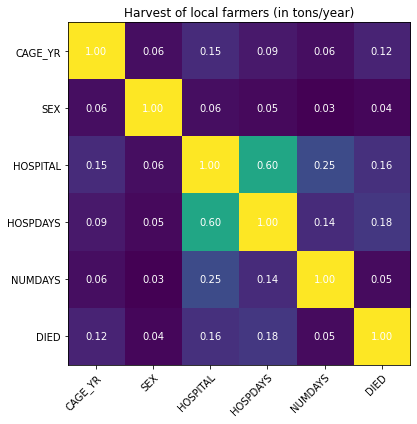

In [82]:
# plt.figure(figsize=(15,10))
# sns.set(font_scale = 1.5)
# sns.heatmap(corr, annot = True, cmap = 'plasma', vmin = -1, vmax = 1, linecolor='white', linewidths= 1)
cor = ["CAGE_YR", "SEX", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "DIED"]

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(corr)

ax.set_xticks(np.arange(len(cor)), labels=cor)
ax.set_yticks(np.arange(len(cor)), labels=cor)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(cor)):
    for j in range(len(cor)):
        text = ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

In [16]:
# sns.set(font_scale = 1.5)
# sns.pairplot(data=df, hue='DIED', diag_kind='kde', palette='Set2')

# Model

## Article Prior

In [84]:
df_data_2020 = pd.read_csv("../dane/2020VAERSDATA.csv", encoding='latin1', low_memory=False)
df_vax_2020 = pd.read_csv("../dane/2020VAERSVAX.csv", encoding='latin1', low_memory=False)
df_2020 = pd.merge(df_data_2020, df_vax_2020, on='VAERS_ID')

df_data_2021 = pd.read_csv("../dane/2021VAERSDATA.csv", encoding='latin1', low_memory=False)
df_vax_2021 = pd.read_csv("../dane/2021VAERSVAX.csv", encoding='latin1', low_memory=False)
df_2021 = pd.merge(df_data_2021, df_vax_2021, on='VAERS_ID')

df_article = pd.concat([df_2020, df_2021])
df_article = df_article.set_index('VAERS_ID')

In [85]:
df_article['RECVDATE'] = pd.to_datetime(df_article['RECVDATE'], format='%m/%d/%Y')

start_date = '2020-12-14'
end_date = '2021-01-22'

df_article = df_article[(df_article['RECVDATE'] >= start_date) & (df_article['RECVDATE'] <= end_date)]

df_article = df_article[["STATE", "CAGE_YR", "SEX", "DIED", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "VAX_TYPE", "VAX_MANU"]]

df_article.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64921 entries, 901875 to 2642529
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   STATE     52156 non-null  object 
 1   CAGE_YR   56362 non-null  float64
 2   SEX       64921 non-null  object 
 3   DIED      349 non-null    object 
 4   HOSPITAL  1044 non-null   object 
 5   HOSPDAYS  653 non-null    float64
 6   NUMDAYS   60416 non-null  float64
 7   VAX_TYPE  64921 non-null  object 
 8   VAX_MANU  64921 non-null  object 
dtypes: float64(3), object(6)
memory usage: 5.0+ MB


In [86]:
df_article = df_article[df_article["SEX"].isin(["F", "M"])]
df_article['SEX'] = df_article['SEX'].apply(lambda x: 1 if x == 'M' else 0)
df_article = df_article.dropna(subset=["STATE", "CAGE_YR", "NUMDAYS"])
df_article['DIED'] = df_article['DIED'].apply(lambda x: 1 if x == 'Y' else 0)
df_article['HOSPITAL'] = df_article['HOSPITAL'].apply(lambda x: 1 if x == 'Y' else 0)
df_article['HOSPDAYS'] = pd.to_numeric(df_article['HOSPDAYS'], errors='coerce').fillna(0)

df_article = df_article[df_article["NUMDAYS"] <= 90]

df_article.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45649 entries, 901875 to 2642010
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   STATE     45649 non-null  object 
 1   CAGE_YR   45649 non-null  float64
 2   SEX       45649 non-null  int64  
 3   DIED      45649 non-null  int64  
 4   HOSPITAL  45649 non-null  int64  
 5   HOSPDAYS  45649 non-null  float64
 6   NUMDAYS   45649 non-null  float64
 7   VAX_TYPE  45649 non-null  object 
 8   VAX_MANU  45649 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 3.5+ MB


In [87]:
df_article.describe()

,CAGE_YR,SEX,DIED,HOSPITAL,HOSPDAYS,NUMDAYS
count,45649.000000,45649.000000,45649.000000,45649.000000,45649.000000,45649.000000
mean,45.371837,0.193104,0.006134,0.017613,0.035247,2.026375
std,16.623778,0.394738,0.078079,0.131540,0.439273,4.233492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,44.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,57.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,104.000000,1.000000,1.000000,1.000000,30.000000,90.000000


In [122]:
model_ppc = CmdStanModel(stan_file='../models/model_1_prior.stan')

R = 100
dict = {
        "N": len(df_article),
        "sex": df_article["SEX"],
        "age": df_article["CAGE_YR"]
}

sim_data_art = model_ppc.sample(data=dict,
                        iter_sampling=R,
                        iter_warmup=1,
                        refresh=R,
                        fixed_param=True,
                        chains=1)

INFO:cmdstanpy:compiling stan file /root/models/model_1_prior.stan to exe file /root/models/model_1_prior
INFO:cmdstanpy:compiled model executable: /root/models/model_1_prior
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:02 Sampling completed                    


INFO:cmdstanpy:CmdStan done processing.


In [123]:
sim_prior_model_1_1 = sim_data_art.draws_pd()

death_pred_prior_1_1 = sim_data_art.stan_variable("death")
p_1_1 = sim_data_art.stan_variable("p")
alpha_1_1 = sim_data_art.stan_variable("alpha")
beta_age_1_1 = sim_data_art.stan_variable("beta_age")
beta_sex_1_1 = sim_data_art.stan_variable("beta_sex")

In [124]:
p_1_1 = p.flatten()
death_pred_prior_1_1 = death_pred_prior_1_1.flatten()

In [125]:
print(death_pred_prior_1_1.mean())
print(df_article["DIED"].mean())

0.0061815154767902915
0.006133759775679643


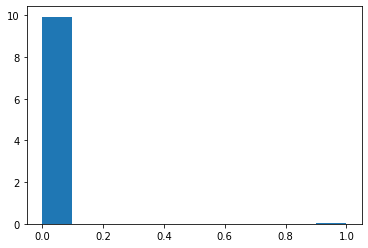

In [126]:
plt.hist(death_pred_prior_1_1, density=True)
plt.show()

## Data Prior

In [127]:
R = 100
dict = {
        "N": len(df),
        "sex": df["SEX"],
        "age": df["CAGE_YR"]
}

sim_data_real = model_ppc.sample(data=dict,
                        iter_sampling=R,
                        iter_warmup=1,
                        refresh=R,
                        fixed_param=True,
                        chains=1)

INFO:cmdstanpy:CmdStan start processing


chain 1 |██████████| 00:02 Sampling completed                    


INFO:cmdstanpy:CmdStan done processing.


In [128]:
sim_prior_model_1_2 = sim_data_real.draws_pd()

death_pred_prior_1_2 = sim_data_real.stan_variable("death")
p_1_2 = sim_data_real.stan_variable("p")
alpha_1_2 = sim_data_real.stan_variable("alpha")
beta_age_1_2 = sim_data_real.stan_variable("beta_age")
beta_sex_1_2 = sim_data_real.stan_variable("beta_sex")

In [129]:
p_1_2 = p.flatten()
death_pred_prior_1_2 = death_pred_prior_1_2.flatten()
print(death_pred_prior_1_2.mean())
print(df["DIED"].mean())

0.01589133970086351
0.016583064202111822


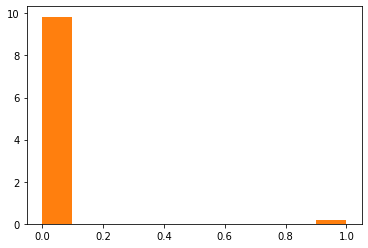

In [131]:
plt.hist(death_pred_prior_1_2, density=True)
# plt.hist(p_1_2, density=True)
plt.hist(df["DIED"], density=True)
plt.show()

## Data Posterion

In [133]:
model_posterior = CmdStanModel(stan_file='../models/model_1_posterior.stan')

INFO:cmdstanpy:compiling stan file /root/models/model_1_posterior.stan to exe file /root/models/model_1_posterior
INFO:cmdstanpy:compiled model executable: /root/models/model_1_posterior


In [134]:
R = 1000
dict = {
        "N": len(df),
        "age": df["CAGE_YR"],
        "sex": df["SEX"],
        "death": df["DIED"]
    }

fit = model_posterior.sample(data=dict, seed=42)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status




chain 1 |▉         | 00:11 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:41 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 01:02 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 01:20 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 01:38 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 01:53 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 02:05 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 02:17 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 02:30 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▍    | 02:44 Iteration: 1000 / 2000 [ 50%]  (Warmup)




chain 1 |█████▉    | 03:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 03:18 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 03:34 Iteration: 1200 / 2000 [ 6


INFO:cmdstanpy:CmdStan done processing.


In [136]:
death_pred_posterior = fit.stan_variable("death_pred")

In [174]:
# from scipy.stats import mode

# death_pred_posterior[3998].mean()

# yields_pred_posterior_max = np.mean(death_pred_posterior, axis=0)
# most_common_values = mode(death_pred_posterior, axis=1)

death_pred_mean = np.mean(death_pred_posterior, axis=0)

In [178]:
death_pred_mean.max()

0.1395

In [179]:
death_pred_posterior.max()

1.0

In [172]:
# most_common_values_in_columns.mean()

0.0

In [173]:
print(death_pred_posterior_1.mean())

0.016738490345633204


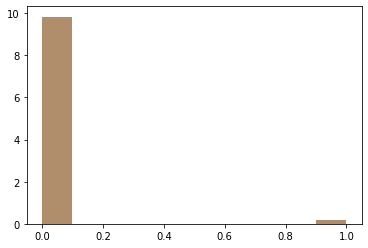

In [142]:
plt.hist(death_pred_posterior_1, density=True, alpha=0.7)
plt.hist(df["DIED"], density=True, alpha=0.5)
plt.show()

In [143]:
from sklearn.metrics import  roc_curve, auc ,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

conf_matrix = confusion_matrix(df["DIED"], death_pred_posterior_1)

ValueError: Found input variables with inconsistent numbers of samples: [43659, 174636000]

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(25,15))

ax[0][0].hist(x=df["CAGE_YR"], bins=50, density=True, alpha=0.7)
ax[0][0].hist(x=death_pred_prior, bins=50, density=True, alpha=0.7)
ax[0][0].legend(["real", "simulated"])
ax[0][0].set_title("AGE distributioin")

ax[0][1].hist(x=df["SEX"], density=True, alpha=0.8)
# ax[0][1].hist(x=sim_prior_model_1_1["sex[1]"], density=True, alpha=0.6)
ax[0][1].legend(["real", "simulated"])
ax[0][1].set_title("SEX distribution")

ax[1][0].hist(x=df_article["DIED"], density=True, alpha=0.9)
ax[1][0].hist(x=sim_prior_model_1_1["death[3]"], density=True, alpha=0.6)
ax[1][0].legend(["real", "simulated"])
ax[1][0].set_title("NUMDAYS distribution")

plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.show()

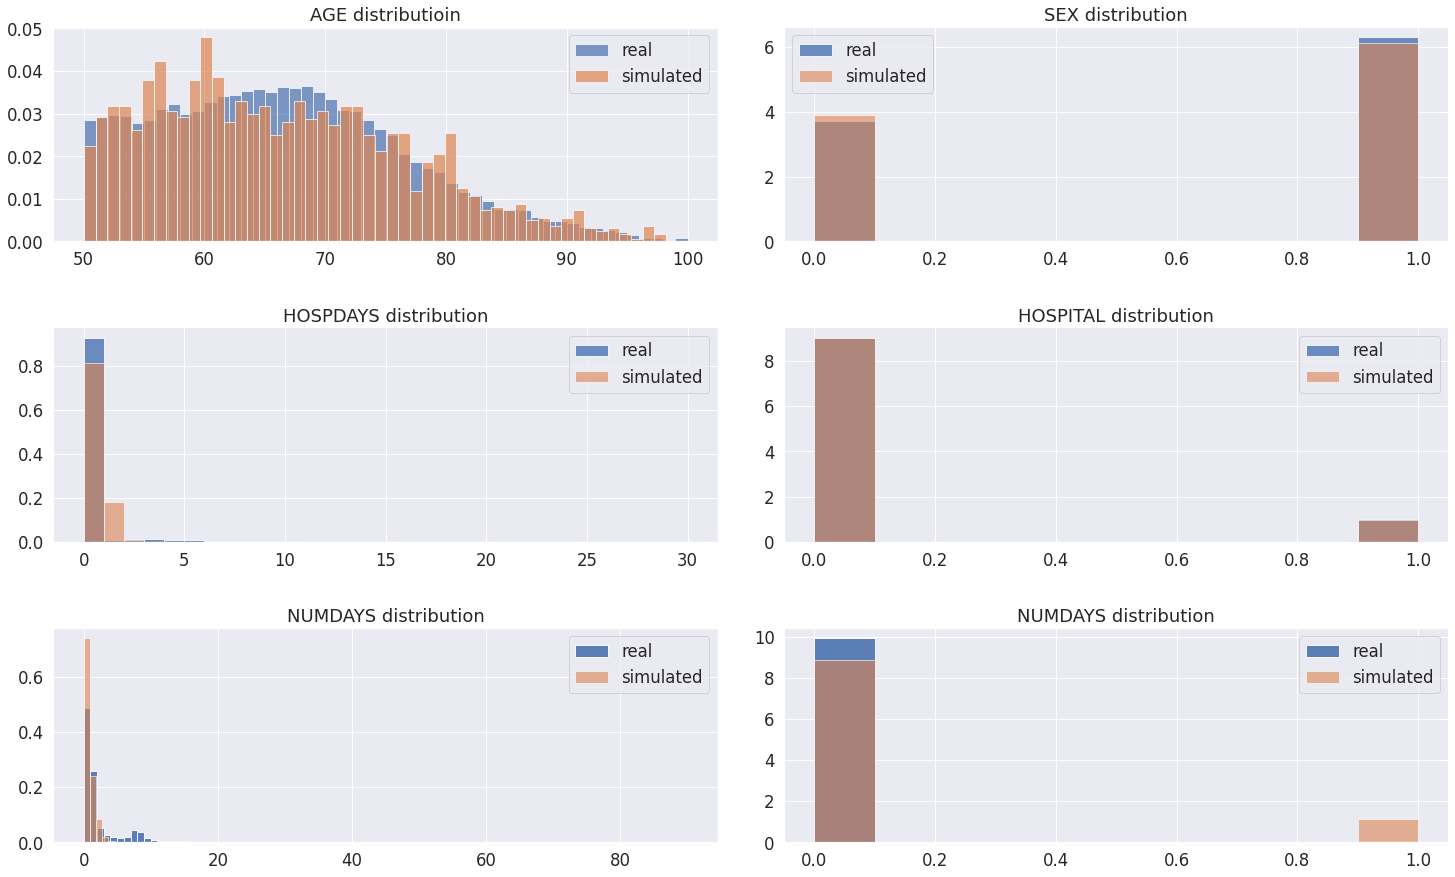

In [170]:
fig, ax = plt.subplots(3, 2, figsize=(25,15))

ax[0][0].hist(x=df["CAGE_YR"], bins=50, density=True, alpha=0.7)
ax[0][0].hist(x=sim_prior_1["age"], bins=50, density=True, alpha=0.7)
ax[0][0].legend(["real", "simulated"])
ax[0][0].set_title("AGE distributioin")

ax[0][1].hist(x=df["SEX"], density=True, alpha=0.8)
ax[0][1].hist(x=sim_prior_1["sex"], density=True, alpha=0.6)
ax[0][1].legend(["real", "simulated"])
ax[0][1].set_title("SEX distribution")

ax[1][0].hist(x=df["HOSPDAYS"], bins=30, density=True, alpha=0.8)
ax[1][0].hist(x=sim_prior_1["hospital_days"],bins=3, density=True, alpha=0.6)
ax[1][0].legend(["real", "simulated"])
ax[1][0].set_title("HOSPDAYS distribution")

ax[1][1].hist(x=df["HOSPITAL"], density=True, alpha=0.8)
ax[1][1].hist(x=sim_prior_1["hospital"], density=True, alpha=0.6)
ax[1][1].legend(["real", "simulated"])
ax[1][1].set_title("HOSPITAL distribution")

ax[2][0].hist(x=df_article["NUMDAYS"], bins=90, density=True, alpha=0.9)
ax[2][0].hist(x=sim_prior_1["numdays"], bins=5, density=True, alpha=0.6)
ax[2][0].legend(["real", "simulated"])
ax[2][0].set_title("NUMDAYS distribution")

ax[2][1].hist(x=df_article["DIED"], density=True, alpha=0.9)
ax[2][1].hist(x=sim_prior_1["death"], density=True, alpha=0.6)
ax[2][1].legend(["real", "simulated"])
ax[2][1].set_title("NUMDAYS distribution")

plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.show()

In [164]:
df_article["DIED"].value_counts()

0    45369
1      280
Name: DIED, dtype: int64

In [172]:
sim_prior_1["death"].value_counts()

0.0    1477
1.0     189
Name: death, dtype: int64

In [160]:
df_article.describe()

,CAGE_YR,SEX,DIED,HOSPITAL,HOSPDAYS,NUMDAYS
count,45649.000000,45649.000000,45649.000000,45649.000000,45649.000000,45649.000000
mean,45.371837,0.806896,0.006134,0.017613,0.035247,2.026375
std,16.623778,0.394738,0.078079,0.131540,0.439273,4.233492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,44.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,57.000000,1.000000,0.000000,0.000000,0.000000,2.000000
max,104.000000,1.000000,1.000000,1.000000,30.000000,90.000000


# Prior - SEX, CAGE_YR

In [229]:
model_ppc = CmdStanModel(stan_file='../models/model_1_prior.stan')

R = 1000
dict = {
        "N": len(df_article),
        "sex": df_article["SEX"],
        "ages": df_article["CAGE_YR"]
}

sim_data = model_ppc.sample(data=dict,
                        iter_sampling=R,
                        iter_warmup=1,
                        refresh=R,
                        fixed_param=True,
                        chains=1)


INFO:cmdstanpy:compiling stan file /root/models/model_1_prior.stan to exe file /root/models/model_1_prior
INFO:cmdstanpy:compiled model executable: /root/models/model_1_prior
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:36 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [235]:
# sim_prior_model_1_1.stan_variable("death[1]") #["death"].value_counts()
sim_prior_model_1_1 = sim_data.draws_pd()
death_pred_prior = sim_data.stan_variable("death")
#  = sim.stan_variable("yields")

In [1]:
fig, ax = plt.subplots(2, 2, figsize=(25,15))

ax[0][0].hist(x=df["CAGE_YR"], bins=50, density=True, alpha=0.7)
ax[0][0].hist(x=death_pred_prior, bins=50, density=True, alpha=0.7)
ax[0][0].legend(["real", "simulated"])
ax[0][0].set_title("AGE distributioin")

ax[0][1].hist(x=df["SEX"], density=True, alpha=0.8)
# ax[0][1].hist(x=sim_prior_model_1_1["sex[1]"], density=True, alpha=0.6)
ax[0][1].legend(["real", "simulated"])
ax[0][1].set_title("SEX distribution")

ax[1][0].hist(x=df_article["DIED"], density=True, alpha=0.9)
ax[1][0].hist(x=sim_prior_model_1_1["death[3]"], density=True, alpha=0.6)
ax[1][0].legend(["real", "simulated"])
ax[1][0].set_title("NUMDAYS distribution")

plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.show()

NameError: name 'plt' is not defined

# POSTERION

In [214]:
model_ppc = CmdStanModel(stan_file='../models/model_1.stan')

INFO:cmdstanpy:compiling stan file /root/models/model_1.stan to exe file /root/models/model_1
ERROR:cmdstanpy:Stan program failed to compile:
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/models/model_1.hpp /root/models/model_1.stan
Semantic error in '/root/models/model_1.stan', line 10, column 2 to column 15:
   -------------------------------------------------
     8:  parameters {
     9:    real intercept;
    10:    int beta_sex;
           ^
    11:    real beta_age;
    12:  }
   -------------------------------------------------

(Transformed) Parameters cannot be integers.
make: *** [make/program:50: /root/models/model_1.hpp] Error 1

Command ['make', '/root/models/model_1']
	error during processing No such file or directory



ValueError: Unable to compile Stan model file: /root/models/model_1.stan.

In [ ]:


R = 1000
dict = {
        "N": len(df_article),
        "sex": df_article["SEX"],
        "ages": df_article["CAGE_YR"]
}

sim_data = model_ppc.sample(data=dict,
                        iter_sampling=R, 
                        iter_warmup=1,
                        refresh=R,
                        fixed_param=True,
                        chains=1)

sim_prior_model_1_1 = sim_data.draws_pd()